In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sbn
import numpy as np 
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

# load results 

The results file can be generated using `scripts/agg_results.py`

In [8]:
res = pd.read_csv('../output/results01.csv')
res = res.assign(name=[f'model={m}_rand={bool(r)}_cag={bool(ca)}' for m,r,ca in res[['model', 'randomize', 'cell_agnostic']].values ])
res = res.assign(fold=lambda x: [x.split('/')[-1].split('-')[-1] for x in x.fold.values])# FOLD.str.split(pat='/', expand=True)
res = res.assign(exp=lambda x: [x.split('/')[2] for x in x.data.values])# FOLD.str.split(pat='/', expand=True)
res = res.assign(model2 = [m if r == 0 else m + '-rand' for m,r in res[['model', 'randomize']].values])
res.head()

,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,fold,gnn,...,init,no_bias,no_residual,null_inflation,scale_channels_by_degree,share_layers,two_layer_conv,name,exp,model2
0,25.0,0.0,128.0,mse,../output/exp1//proc/,cuda,0.0,100.0,8,GIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp1,gnn
1,25.0,0.0,128.0,mse,../output/exp1//proc/,cuda,0.0,100.0,8,GIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp1,gnn
2,25.0,0.0,128.0,mse,../output/exp1//proc/,cuda,0.0,100.0,8,GIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp1,gnn
3,25.0,0.0,128.0,mse,../output/exp1//proc/,cuda,0.0,100.0,8,GIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp1,gnn
4,25.0,0.0,128.0,mse,../output/exp1//proc/,cuda,0.0,100.0,8,GIN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,model=gnn_rand=False_cag=False,exp1,gnn


In [9]:
order = np.sort(res.exp.unique())
order

array(['exp1'], dtype=object)

# Use `val` set to choose best model within each experiment replicate

In [10]:
# metric which will choose "best" model (by max value)
metric = 'mean_r_val' #'r_cell_val' ##'mse_val' #'r2_val' # 'r_flat_val'
lower_is_better = False

In [12]:
bres = res[lambda x: ~x[metric].isna()].sort_values(metric, ascending=lower_is_better).drop_duplicates(['EXP_ID', 'fold', 'model', 'randomize', 'cell_agnostic'])

bres.head()

,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,fold,gnn,...,init,no_bias,no_residual,null_inflation,scale_channels_by_degree,share_layers,two_layer_conv,name,exp,model2
282,25.0,0.0,20.0,mse,../output/exp1//proc/,cuda,0.1,100.0,5,NaN,...,xavier,0.0,0.0,0.0,0.0,0.0,0.0,model=gsnn_rand=False_cag=False,exp1,gsnn
123,25.0,0.0,20.0,mse,../output/exp1//proc/,cuda,0.1,100.0,3,NaN,...,xavier,0.0,0.0,0.0,0.0,0.0,0.0,model=gsnn_rand=False_cag=False,exp1,gsnn
159,25.0,0.0,20.0,mse,../output/exp1//proc/,cuda,0.1,100.0,4,NaN,...,xavier,0.0,0.0,0.0,0.0,0.0,0.0,model=gsnn_rand=False_cag=False,exp1,gsnn
14,25.0,0.0,20.0,mse,../output/exp1//proc/,cuda,0.1,100.0,8,NaN,...,xavier,0.0,0.0,0.0,0.0,0.0,0.0,model=gsnn_rand=False_cag=False,exp1,gsnn
132,256.0,0.0,1000.0,mse,../output/exp1//proc/,cpu,0.5,100.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,model=nn_rand=False_cag=False,exp1,nn


In [14]:
order = [x for x in ['exp' + str(i) for i in range(12)] if x in bres.exp.unique()]
order

['exp1']

# Paired T-Test Comparison

In [16]:
metric = 'mean_r_test'

print('\\begin{tabular}{|l|l|l|}')
print('\\hline')
print('EXP. ID & H0 & p-value \\\\ \\hline')

exps = np.sort(bres.exp.unique())

for i in range(12): 
    exp = f'exp{i}'
    if exp not in exps: continue 

    tmp = bres[lambda x: x.exp == exp]
    group1 = tmp[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].sort_values(by='EXP_ID')
    group2 = tmp[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0)].sort_values(by='EXP_ID')
    df = group1.merge(group2, on=['EXP_ID'], how='inner')
    score1 = df[f'{metric}_x'].values
    score2 = df[f'{metric}_y'].values

    ttest_res = ttest_rel(score1, score2, alternative='two-sided')

    if ttest_res.statistic < 0: 
        print(exp, '&', 'GSNN > NN &', f'{ttest_res.pvalue:.3f}', end='')
        #print(f'EXP: {exp} \t-->  NN performs better than GSNN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')
    else: 
        print(exp, '&', 'NN > GSNN &', f'{ttest_res.pvalue:.3f}', end='')
        #print(f'EXP: {exp} \t-->  GSNN performs better than NN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')

    if ttest_res.pvalue <= 0.05: 
        print('**\\\\ \\hline')
    else: 
        print('\\\\ \\hline')

print('\\end{tabular}')

\begin{tabular}{|l|l|l|}
\hline
EXP. ID & H0 & p-value \\ \hline
exp1 & NN > GSNN & 0.000**\\ \hline
\end{tabular}


In [17]:
metric = 'r_cell_test'

print('\\begin{tabular}{|l|l|l|}')
print('\\hline')
print('EXP. ID & H0 & p-value \\\\ \\hline')

exps = np.sort(bres.exp.unique())

for i in range(12): 
    exp = f'exp{i}'
    if exp not in exps: continue 

    tmp = bres[lambda x: x.exp == exp]
    group1 = tmp[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].sort_values(by='EXP_ID')
    group2 = tmp[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0)].sort_values(by='EXP_ID')
    df = group1.merge(group2, on=['EXP_ID'], how='inner')
    score1 = df[f'{metric}_x'].values
    score2 = df[f'{metric}_y'].values

    ttest_res = ttest_rel(score1, score2, alternative='two-sided')

    if ttest_res.statistic < 0: 
        print(exp, '&', 'GSNN > NN &', f'{ttest_res.pvalue:.3f}', end='')
        #print(f'EXP: {exp} \t-->  NN performs better than GSNN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')
    else: 
        print(exp, '&', 'NN > GSNN &', f'{ttest_res.pvalue:.3f}', end='')
        #print(f'EXP: {exp} \t-->  GSNN performs better than NN [p-value: {ttest_res.pvalue:.2f}] || GSNN mean: {score1.mean():.2f} || NN mean {score2.mean():.2f}')

    if ttest_res.pvalue <= 0.05: 
        print('**\\\\ \\hline')
    else: 
        print('\\\\ \\hline')

print('\\end{tabular}')


\begin{tabular}{|l|l|l|}
\hline
EXP. ID & H0 & p-value \\ \hline
exp1 & NN > GSNN & 0.000**\\ \hline
\end{tabular}


# Number of model parameters: GSNN vs NN

In [18]:
exps = np.sort(bres.exp.unique())


print('\\begin{tabular}{|l|l|l|l|}')
print('\\hline')
print('EXP. ID & Num. GSNN params (min, median, max) & Num. NN params (min, median, max) & Ratio of Median Num. params \\\\ \\hline')

rs = []
for i in range(12): 
    exp = f'exp{i}'
    if exp not in exps: continue 

    tmp = bres[lambda x: x.exp == exp]
    group1 = tmp[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].sort_values(by='EXP_ID')
    group2 = tmp[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0)].sort_values(by='EXP_ID')
    df = group1.merge(group2, on=['EXP_ID'], how='inner')

    n1 = df.n_params_x.median()
    n2 = df.n_params_y.median()

    ratio_of_params_nn_vs_gsnn = n2 / n1
    rs.append(ratio_of_params_nn_vs_gsnn)

    print(exp, '&', f'{int(df.n_params_x.min())}, {int(df.n_params_x.median())}, {int(df.n_params_x.max())}', '&', f'{int(df.n_params_y.min())}, {int(df.n_params_y.median())}, {int(df.n_params_y.max())}', '&', f'{ratio_of_params_nn_vs_gsnn:.1f}', end=' \\\\ \\hline\n')

print('AVG.', '&', '', '&', '', '&', f'{np.mean(rs):.1f}', end=' \\\\ \\hline\n')

print('\\end{tabular}')


\begin{tabular}{|l|l|l|l|}
\hline
EXP. ID & Num. GSNN params (min, median, max) & Num. NN params (min, median, max) & Ratio of Median Num. params \\ \hline
exp1 & 5550480, 5550480, 5550480 & 4964453, 4964453, 4964453 & 0.9 \\ \hline
AVG. &  &  & 0.9 \\ \hline
\end{tabular}


# Computational Complexity of the GSNN method

In [19]:
exps = np.sort(bres.exp.unique())
exp_order = [f'exp{i}' for i in range(12) if f'exp{i}' in exps]


timeres = res.groupby(['exp', 'model'])[['time_elapsed']].median().reset_index().pivot(index='exp', columns='model', values='time_elapsed')
timeres = timeres.assign(**{'gnn (min)':lambda x: x.gnn/60, 'gsnn (min)':lambda x: x.gsnn/60, 'nn (min)':lambda x: x.nn/60})
timeres = timeres.assign(gsnn_div_nn = lambda x: x.gsnn / x.nn, gsnn_div_gnn= lambda x: x.gsnn / x.gnn)
timeres = timeres.loc[exp_order, ['gsnn (min)', 'gnn (min)', 'nn (min)', 'gsnn_div_nn', 'gsnn_div_gnn']]

print('\\begin{tabular}{|l|l|l|l|l|l|}')
print('\\hline')
print('EXP. & GSNN (min) & GNN (min) & NN (min) & GSNN / NN & GSNN / GNN \\\\ \\hline')


for exp,row in timeres.iterrows(): 
    print(exp, '&', ' & '.join([str(f'{x:.1f}') for x in row.values]), end=' \\\\ \\hline\n')

print('\\end{tabular}')

\begin{tabular}{|l|l|l|l|l|l|}
\hline
EXP. & GSNN (min) & GNN (min) & NN (min) & GSNN / NN & GSNN / GNN \\ \hline
exp1 & 375.3 & 68.1 & 34.2 & 11.0 & 5.5 \\ \hline
\end{tabular}


In [20]:
# proportion of best GSNN models that only required 20 training epochs 
(bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0.)].eval_at_epoch < 21).mean()

0.0

# GSNN num layers vs perf. 

In [21]:
# number opf best performing models with each # layer hyperparameters 
bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0)].groupby('layers')['model'].count()

layers
20.0    8
Name: model, dtype: int64

ValueError: min() arg is an empty sequence

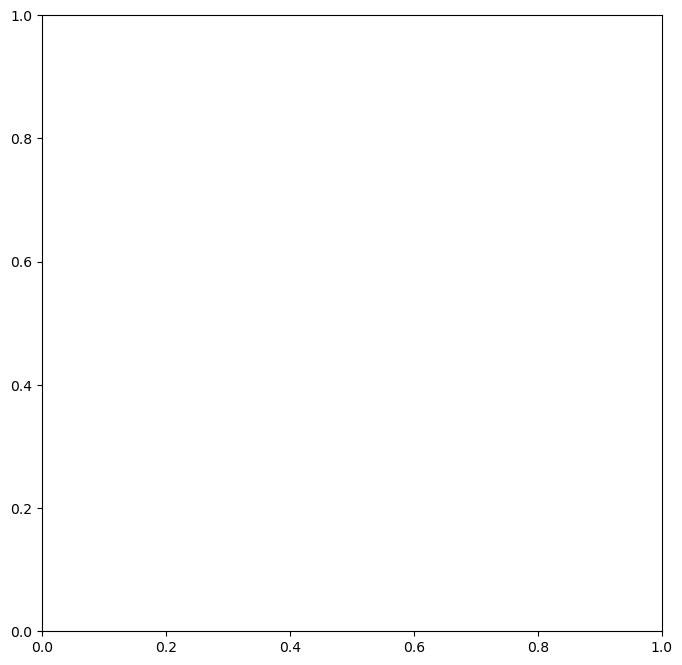

In [22]:
f,ax = plt.subplots(1,1, figsize=(8,8))
sbn.boxplot(y='r_flat_test', x='EXP_ID', hue='layers', data=res[lambda x: (x.model == 'gsnn') & (x.randomize == 0) & (x.exp == 'exp5')], ax=ax)
plt.grid()
plt.show()

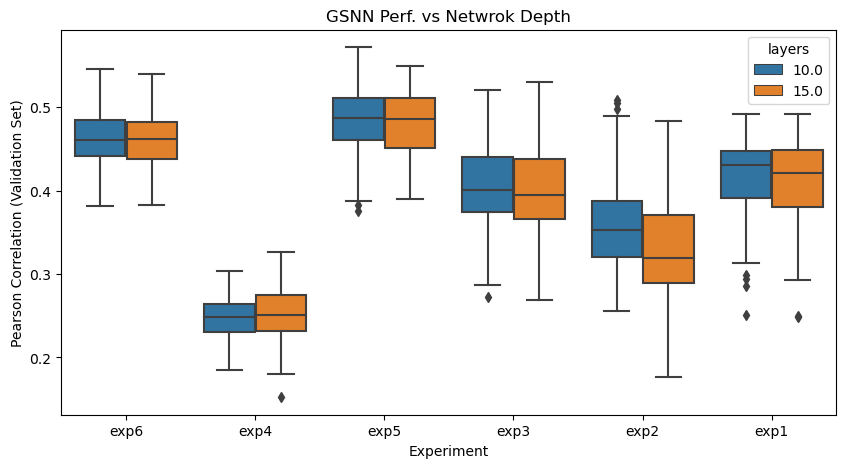

In [46]:
plt.figure(figsize=(10,5))
sbn.boxplot(x='exp', y='r_flat_val', hue='layers', data=res[lambda x: (x.model == 'gsnn') & (x.randomize == 0)])
plt.title('GSNN Perf. vs Netwrok Depth')
plt.xlabel('Experiment')
plt.ylabel('Pearson Correlation (Validation Set)')
plt.show()

In [47]:
df = res[lambda x: (x.model == 'gsnn') & (x.randomize == 0)]
df = df.merge(df[['EXP_ID', 'r_flat_val']].groupby('EXP_ID').agg(['mean', 'var']).reset_index(), on='EXP_ID')
df = df.assign(exp_norm_r_flat_val=lambda x: (x.r_flat_val - x['r_flat_val', 'mean'])/x['r_flat_val', 'var'])
df.head()

/tmp/ipykernel_7653/2144868085.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(df[['EXP_ID', 'r_flat_val']].groupby('EXP_ID').agg(['mean', 'var']).reset_index(), on='EXP_ID')
/tmp/ipykernel_7653/2144868085.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(df[['EXP_ID', 'r_flat_val']].groupby('EXP_ID').agg(['mean', 'var']).reset_index(), on='EXP_ID')


,batch,cell_agnostic,channels,crit,data,device,dropout,epochs,gnn,ignore_cuda,...,null_inflation,share_layers,stochastic_depth,name,exp,repl,model2,"(r_flat_val, mean)","(r_flat_val, var)",exp_norm_r_flat_val
0,25.0,0.0,10.0,mse,../output/exp6-3//proc/,cuda,0.1,100.0,NaN,0.0,...,0.05,0.0,0.0,model=gsnn_rand=False_cag=False,exp6,3,gsnn,0.464394,0.000592,34.975837
1,25.0,0.0,10.0,mse,../output/exp6-3//proc/,cuda,0.1,100.0,NaN,0.0,...,0.05,0.0,0.0,model=gsnn_rand=False_cag=False,exp6,3,gsnn,0.464394,0.000592,17.987097
2,25.0,0.0,10.0,mse,../output/exp6-3//proc/,cuda,0.1,100.0,NaN,0.0,...,0.05,0.0,0.0,model=gsnn_rand=False_cag=False,exp6,3,gsnn,0.464394,0.000592,27.894617
3,25.0,0.0,10.0,mse,../output/exp6-3//proc/,cuda,0.1,100.0,NaN,0.0,...,0.05,0.0,0.0,model=gsnn_rand=False_cag=False,exp6,3,gsnn,0.464394,0.000592,32.238567
4,25.0,0.0,10.0,mse,../output/exp6-3//proc/,cuda,0.1,100.0,NaN,0.0,...,0.05,0.0,0.0,model=gsnn_rand=False_cag=False,exp6,3,gsnn,0.464394,0.000592,23.596340


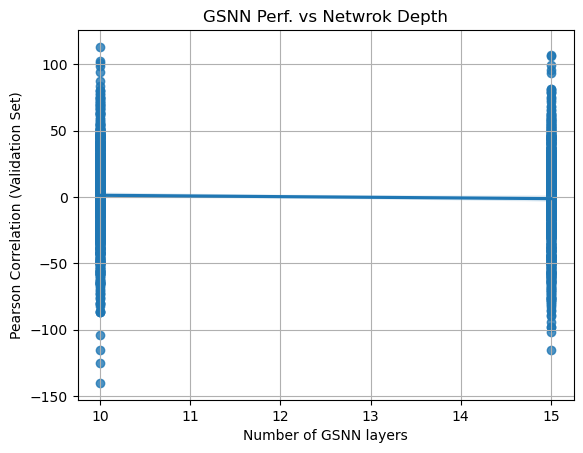

In [48]:
plt.figure()
sbn.regplot(x='layers', y='exp_norm_r_flat_val', data=df)
plt.title('GSNN Perf. vs Netwrok Depth')
plt.xlabel('Number of GSNN layers')
plt.ylabel('Pearson Correlation (Validation Set)')
plt.grid()
plt.show()

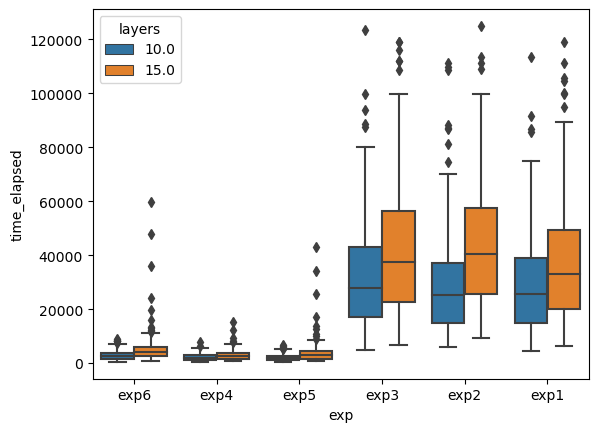

In [49]:
plt.figure()
sbn.boxplot(x='exp', y='time_elapsed', hue='layers', data=res[lambda x: (x.model == 'gsnn') & (x.randomize == 0)])
plt.show()

# GSNN vs NN vs GNN 

Exclude `cell_agnostic` and `randomize` terms. 

In [ ]:
metric = 'mean_r_test'

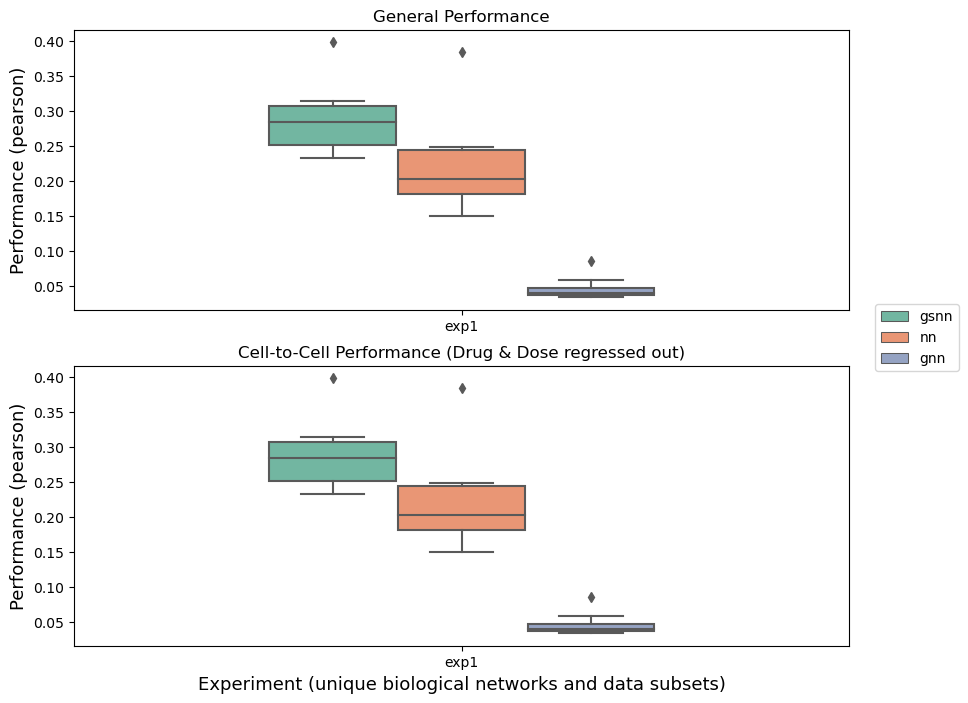

<Figure size 1000x500 with 0 Axes>

In [25]:
fontsize=13

f,axes = plt.subplots(2,1, figsize=(10,8), sharex=False)
g = sbn.boxplot(ax=axes.flat[0], x='exp', y=metric, hue='model2', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0.)], order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))
g.legend(loc='right', bbox_to_anchor=(1.15, -0.1), ncol=1)
axes.flat[0].set_xlabel(None)
axes.flat[0].set_ylabel('Performance (pearson)', fontsize=fontsize)
axes.flat[0].set_title('General Performance')

f = plt.figure(figsize=(10,5))
g = sbn.boxplot(ax=axes.flat[1], x='exp', y='r_cell_test', hue='model2', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0.)], order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))
axes.flat[1].get_legend().set_visible(False)
axes.flat[1].set_ylabel('Performance (pearson)', fontsize=fontsize)
axes.flat[1].set_xlabel('Experiment (unique biological networks and data subsets)', fontsize=fontsize)
axes.flat[1].set_title('Cell-to-Cell Performance (Drug & Dose regressed out)')

plt.tight_layout()
plt.show()

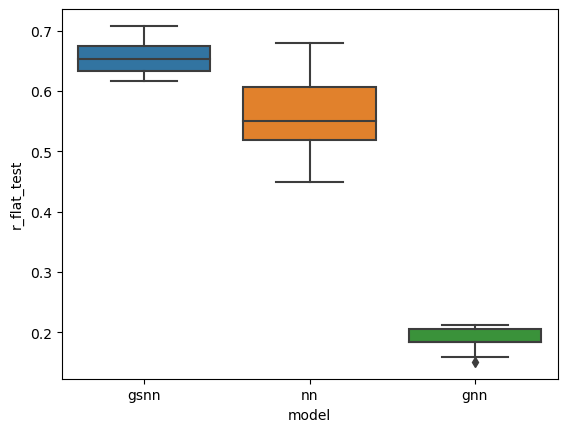

In [24]:
plt.figure()
sbn.boxplot(x='model', y='r_flat_test', data=bres)
plt.show()

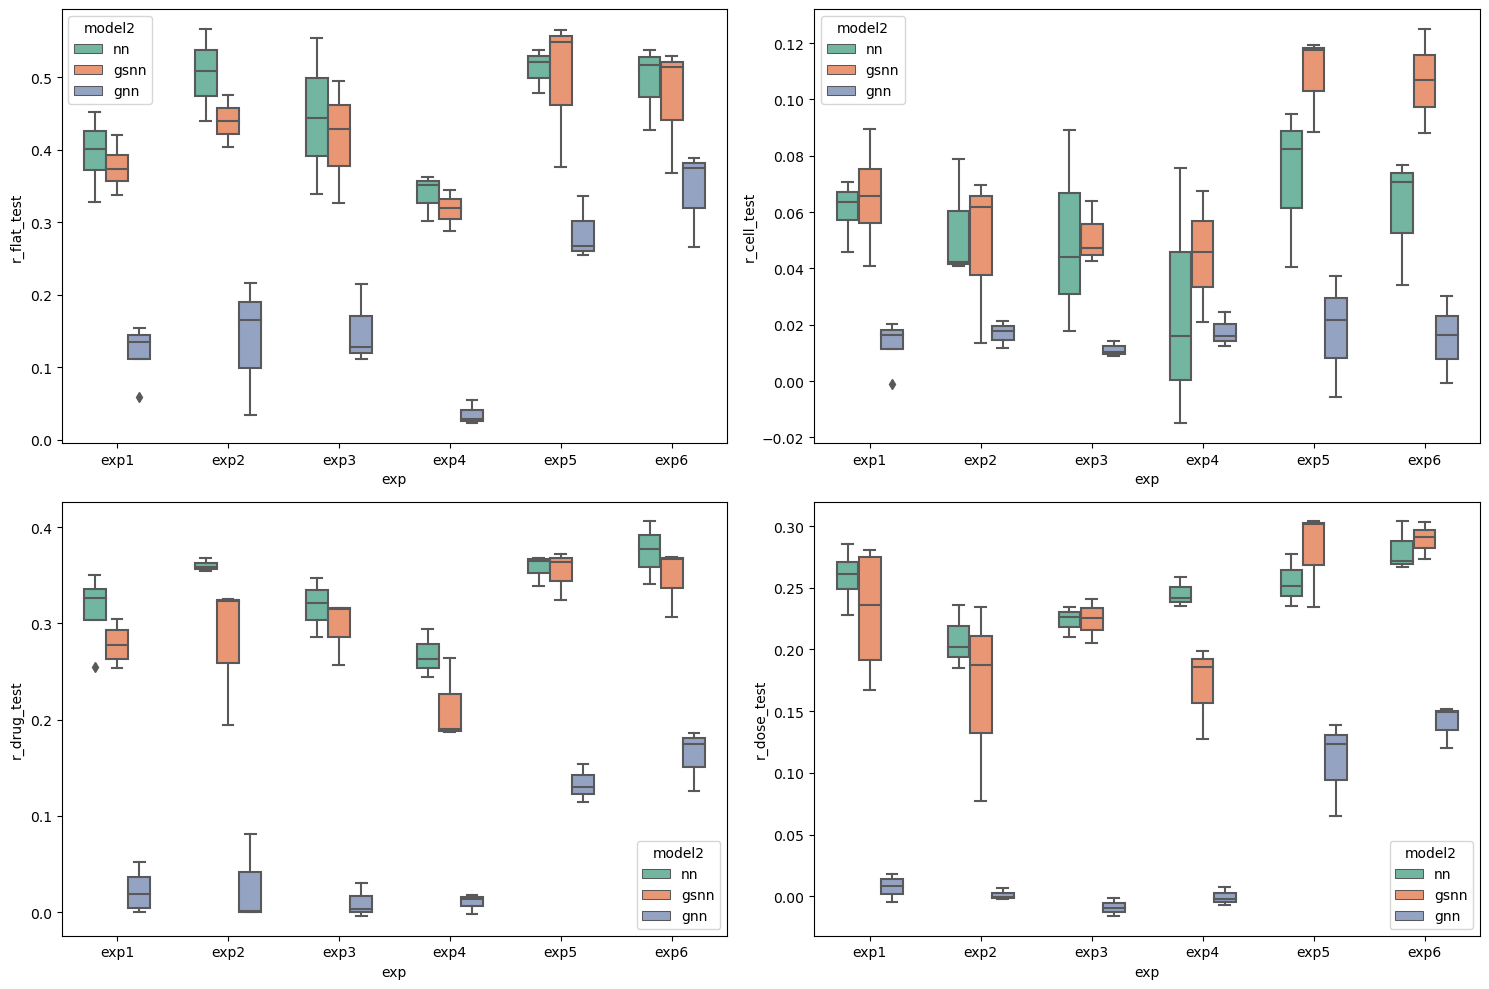

In [52]:
f,axes = plt.subplots(2,2, figsize=(15,10))
for ax, met in zip(axes.flat, ['r_flat_test', 'r_cell_test', 'r_drug_test', 'r_dose_test']):
    sbn.boxplot(x='exp', y=met, hue='model2', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0.)], order=order, width=0.6, orient='v', palette=sbn.color_palette("Set2"), ax=ax)
plt.tight_layout()
plt.show()

# GSNN vs Randomized-GSNN

In [25]:
diffs = []
perc_diffs = []

f=0
for i,row in res[lambda x: (x.model == 'gsnn')][['layers', 'dropout', 'lr', 'channels', 'eval_at_epoch', 'EXP_ID']].drop_duplicates().iterrows(): 

    temp = res[lambda x: (x.layers == row.layers) & (x.dropout == row.dropout) & (x.lr == row.lr) & (x.channels == row.channels) & (x.EXP_ID == row.EXP_ID) & (x.eval_at_epoch == row.eval_at_epoch)]
    
    try: 
        tru = temp[lambda x: x.randomize == 0.]['r_flat_test'].item()
        ran = temp[lambda x: x.randomize == 1.]['r_flat_test'].item()
        diff = tru-ran 
        diffs.append(diff)
        perc_diff = 100*(tru - diff)/((tru + ran)/2)
        perc_diffs.append(perc_diff)
    except:
        f+=1
        print(f'failed [n={f}]', end='\r')

In [26]:
min(perc_diffs)

56.70072602885257

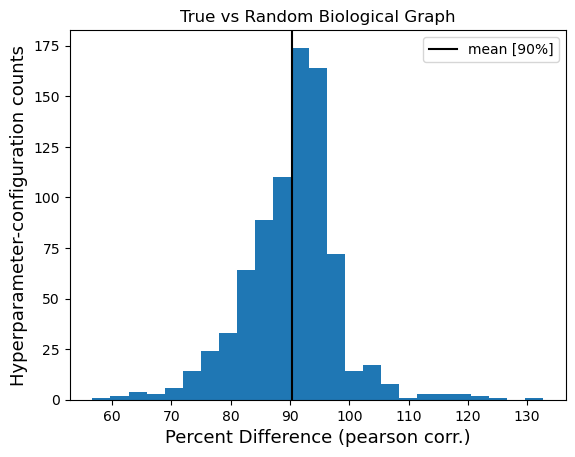

In [27]:
plt.figure()
plt.hist(np.array(perc_diffs), bins=25, density=False)
plt.axvline(np.mean(np.array(perc_diffs)), label=f'mean [{np.mean(perc_diffs):.0f}%]', c='k')
plt.xlabel('Percent Difference (pearson corr.)', fontsize=fontsize)
plt.ylabel('Hyperparameter-configuration counts', fontsize=fontsize)
plt.title('True vs Random Biological Graph')
plt.legend()

plt.show()

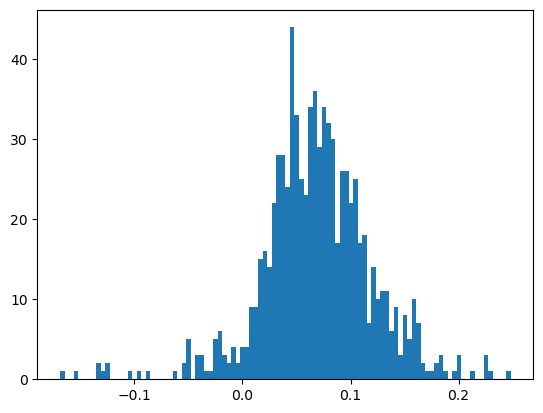

In [28]:
plt.figure()
plt.hist(diffs, bins=100)
plt.show()

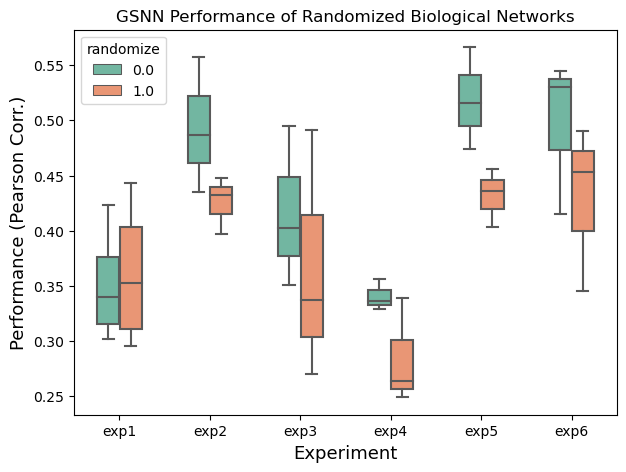

In [29]:
plt.figure(figsize=(7,5))
g = sbn.boxplot(x='exp', y='r_flat_test', hue='randomize', data=bres[lambda x: (x.cell_agnostic.values == 0) & (x.model == 'gsnn')], order=order, width=0.5, orient='v', palette=sbn.color_palette("Set2"))
plt.xlabel('Experiment', fontsize=fontsize)
plt.ylabel('Performance (Pearson Corr.)', fontsize=fontsize)
plt.title('GSNN Performance of Randomized Biological Networks')
plt.show()

# `cell-agnostic` NN cell-cell performance 

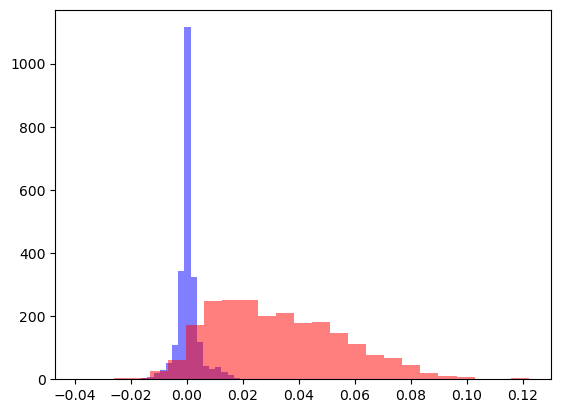

In [30]:
plt.figure()
plt.hist(res[lambda x: (x.model == 'nn') & (x.cell_agnostic == 1.)].r_cell_val, bins=25, color='b', alpha=0.5)
plt.hist(res[lambda x: (x.model == 'nn') & (x.cell_agnostic == 0.)].r_cell_val, bins=25, color='r', alpha=0.5)
plt.show()

# GSNN - what hyper-parameters work best?

In [31]:
bgsnn = bres[lambda x: (x.model == 'gsnn') & (x.randomize == 0.)]

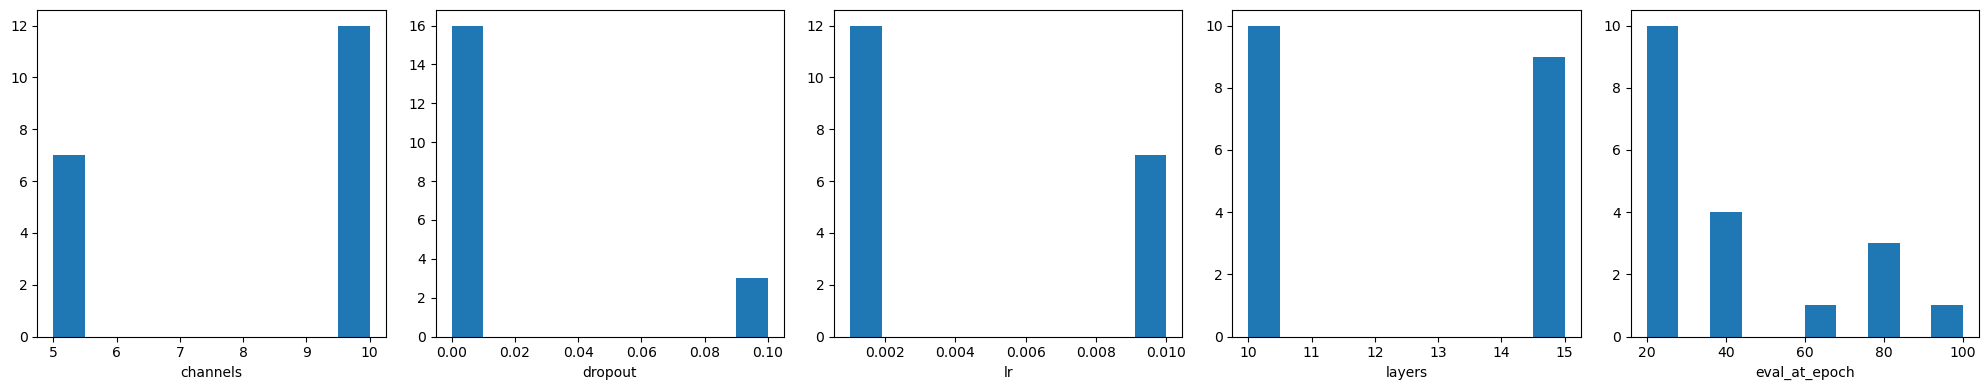

In [32]:
f, axes = plt.subplots(1,5, figsize=(5*4,4))

for ax, hp in zip(axes.flat, ['channels', 'dropout', 'lr', 'layers', 'eval_at_epoch']): 
    ax.hist(bgsnn[hp])
    ax.set_xlabel(hp)

plt.tight_layout()
plt.show()

# GSNN vs NN vs GNN (all hyper-parameter runs)

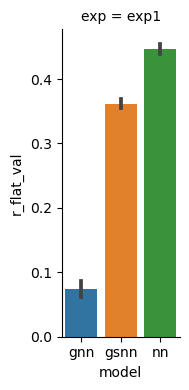

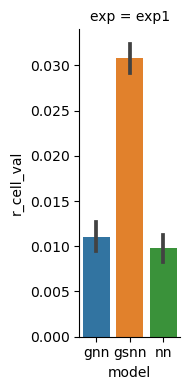

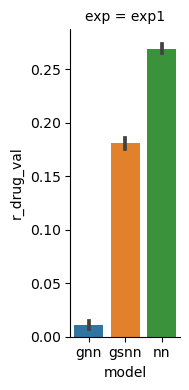

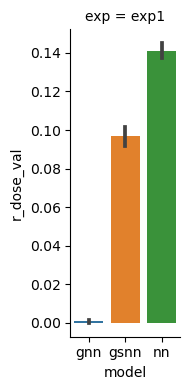

In [47]:
for i,metric in enumerate(['r_flat_val', 'r_cell_val', 'r_drug_val', 'r_dose_val']): 
    sbn.catplot(
        data=res[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0)], x="model", y=metric, col="exp",
        kind="bar", height=4, aspect=.5)


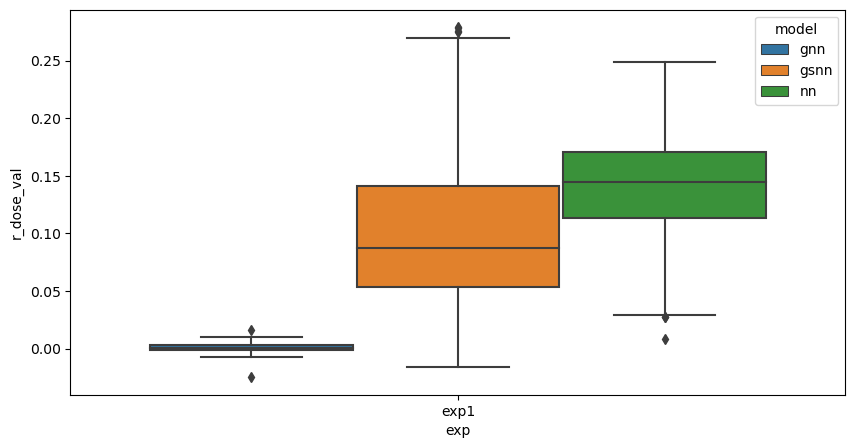

In [48]:
plt.figure(figsize=(10,5))
g = sbn.boxplot(x='exp', y=metric, hue='model', data=res[lambda x: (x.cell_agnostic.values == 0) & (x.randomize.values == 0)], order=order)
plt.show()